# Late Fusion Model by Visit

This notebook analyzes late fusion performance across experimental visits to understand temporal stability.

**Parameterized**: Set `TIMEFRAME` to run PRE or POST analysis.

In [1]:
# ============================================================================
# CONFIGURATION: Set timeframe for analysis
# ============================================================================
TIMEFRAME = 'PRE'  # Options: 'PRE', 'POST'
# ============================================================================

import sys
sys.path.append('../..')  # Add project root to path

import json
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Import from src package
from src.utils.io import load_features, save_results
from src.utils.config import get_model_params, load_config
from src.utils.validation import validate_features, validate_modality_features
from src.models.fusion import weighted_late_fusion
from src.visualization.plots import (
    plot_method_comparison,
    plot_modality_weights,
    set_style
)

np.random.seed(42)
set_style('whitegrid')  # Use shared style function

print(f"\n{'='*70}")
print(f"LATE FUSION ANALYSIS: {TIMEFRAME}-DECISION PERIOD")
print(f"{'='*70}\n")


LATE FUSION ANALYSIS: PRE-DECISION PERIOD



## Load Session Mapping


In [2]:
# Load session mapping to get visit numbers
session_mapping = pd.read_csv('../../data/results/session_mapping.csv', 
                              dtype={'mmdd': str, 'hhmm': str, 'user_id': str})

# Create join key
session_mapping['subject_id'] = session_mapping['mmdd'] + '_' + session_mapping['hhmm'] + '_' + session_mapping['user_id']

print(f"Session mapping: {session_mapping.shape}")
print(f"\nVisit number distribution:")
print(session_mapping['visit_number'].value_counts().sort_index())
session_mapping.head()

Session mapping: (99, 10)

Visit number distribution:
visit_number
1.0    51
2.0    34
3.0     8
Name: count, dtype: int64


,filename,date,time,user_id,mmdd,hhmm,team,session,visit_number,subject_id
0,preprocessing_0816_1400_9M4VCHG.json,08/16/2021,14:00,9M4VCHG,0816,1400,Team 12,Session 3,2.0,0816_1400_9M4VCHG
1,preprocessing_0924_1600_9M4VCHG.json,09/24/2021,16:00,9M4VCHG,0924,1600,Team 24,Session 3,3.0,0924_1600_9M4VCHG
2,preprocessing_0825_1000_9M4VCHG.json,08/25/2021,10:00,9M4VCHG,0825,1000,Team 17,Session 2,2.0,0825_1000_9M4VCHG
3,preprocessing_0813_1600_539136F.json,08/13/2021,16:00,539136F,0813,1600,Team 12,Session 2,1.0,0813_1600_539136F
4,preprocessing_0826_1000_539136F.json,08/26/2021,10:00,539136F,0826,1000,Team 17,Session 3,3.0,0826_1000_539136F


## Load Feature Data

Load the preprocessed behavioral features (gaze, pose, audio)


In [3]:
# Load pre-extracted features
features_path = f'../../data/results/features_{TIMEFRAME}/extracted_features_{TIMEFRAME}.pkl'
feature_data = load_features(features_path, timeframe=TIMEFRAME)

merged_df = feature_data['merged_df']
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

# Validate loaded features
validate_features(merged_df, timeframe=TIMEFRAME)

print(f"  Features extracted on: {feature_data['metadata']['extraction_date']}")
if 'baseline_method' in feature_data['metadata']:
    print(f"  Baseline method: {feature_data['metadata']['baseline_method']}")
print(f"\nFeature counts:")
print(f"  Physiology ({TIMEFRAME}): {len(physio_cols)} features")
print(f"  Behavior: {len(behavior_cols)} features")
print(f"  Gaze: {len(gaze_cols)} features")

✓ Validation passed (PRE): 12511 trials, 97 subjects
  Trials per subject: min=9, max=246, mean=129.0
  Outcome balance: 4273 keep / 8238 invest
  Features extracted on: 2026-01-01 17:53:05
  Baseline method: t3_stable_pre_decision

Feature counts:
  Physiology (PRE): 13 features
  Behavior: 7 features
  Gaze: 20 features


## Prepare Data by Visit Number


In [4]:
# Add visit numbers to merged_df by joining with session_mapping
merged_df = merged_df.merge(
    session_mapping[['subject_id', 'visit_number']],
    on='subject_id',
    how='left'
)

print(f"Merged dataframe: {merged_df.shape}")
print(f"\nTrials with visit_number: {merged_df['visit_number'].notna().sum()} / {len(merged_df)}")
print(f"\nVisit number distribution:")
print(merged_df['visit_number'].value_counts().sort_index())

# Split data by visit
df_visit1 = merged_df[merged_df['visit_number'] == 1.0].copy()
df_visit2 = merged_df[merged_df['visit_number'] == 2.0].copy()
df_visit3 = merged_df[merged_df['visit_number'] == 3.0].copy()

print(f"\nVisit 1: {len(df_visit1)} trials from {df_visit1['subject_id'].nunique()} subjects")
print(f"Visit 2: {len(df_visit2)} trials from {df_visit2['subject_id'].nunique()} subjects")
print(f"Visit 3: {len(df_visit3)} trials from {df_visit3['subject_id'].nunique()} subjects")


Merged dataframe: (12511, 44)

Trials with visit_number: 11751 / 12511

Visit number distribution:
visit_number
1.0    6317
2.0    4495
3.0     939
Name: count, dtype: int64

Visit 1: 6317 trials from 49 subjects
Visit 2: 4495 trials from 34 subjects
Visit 3: 939 trials from 8 subjects


## Feature Extraction Function


In [5]:
# Prepare feature arrays for model training
X_physio = SimpleImputer(strategy='mean').fit_transform(merged_df[physio_cols])
X_behavior = SimpleImputer(strategy='mean').fit_transform(merged_df[behavior_cols])

# Handle gaze features (may be empty in POST)
if len(gaze_cols) > 0:
    X_gaze = SimpleImputer(strategy='mean').fit_transform(merged_df[gaze_cols])
else:
    # Create placeholder array for POST condition (no gaze data)
    X_gaze = np.zeros((len(merged_df), 1))

y = merged_df['outcome'].values
subjects = merged_df['subject_id'].values

print(f"Shapes: X_physio={X_physio.shape}, X_behavior={X_behavior.shape}, X_gaze={X_gaze.shape}")

Shapes: X_physio=(12511, 13), X_behavior=(12511, 7), X_gaze=(12511, 20)


In [6]:
def extract_features_and_labels(df, physio_cols, behavior_cols, gaze_cols):
    """
    Extract feature arrays and labels from a dataframe subset.
    
    Args:
        df: DataFrame containing the data for a specific visit
        physio_cols: List of physiology column names
        behavior_cols: List of behavior column names
        gaze_cols: List of gaze column names
        
    Returns:
        X: Combined feature array (concatenated across modalities)
        y: Label array
        subjects: Subject ID array
    """
    # Extract features for each modality
    X_physio = SimpleImputer(strategy='mean').fit_transform(df[physio_cols])
    X_behavior = SimpleImputer(strategy='mean').fit_transform(df[behavior_cols])
    
    # Handle gaze features (may be empty in POST)
    if len(gaze_cols) > 0:
        X_gaze = SimpleImputer(strategy='mean').fit_transform(df[gaze_cols])
    else:
        # Create placeholder array for POST condition (no gaze data)
        X_gaze = np.zeros((len(df), 1))
    
    # Concatenate all modalities
    X = np.concatenate([X_physio, X_behavior, X_gaze], axis=1)
    
    # Extract labels and subjects
    y = df['outcome'].values
    subjects = df['subject_id'].values
    
    print(f"Features shape: {X.shape}")
    print(f"  Physio: {len(physio_cols)}, Behavior: {len(behavior_cols)}, Gaze: {len(gaze_cols)}")
    print(f"Labels shape: {y.shape}")
    print(f"Unique subjects: {len(np.unique(subjects))}")
    print(f"Label distribution: {np.bincount(y)}")
    
    return X, y, subjects

## LOSO Cross-Validation Function


In [7]:
def run_loso_cv(X, y, subjects, random_state=42):
    """
    Run Leave-One-Subject-Out cross-validation with balanced class weights.
    """
    logo = LeaveOneGroupOut()
    
    all_y_true = []
    all_y_pred = []
    subject_accuracies = []
    
    for train_idx, test_idx in logo.split(X, y, subjects):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train model with balanced class weights
        clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', 
                                     random_state=random_state, n_jobs=-1)
        clf.fit(X_train, y_train)
        
        # Predict
        y_pred = clf.predict(X_test)
        
        # Store results
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        
        # Subject-level accuracy
        subject_acc = accuracy_score(y_test, y_pred)
        subject_accuracies.append(subject_acc)
    
    # Overall metrics
    overall_acc = accuracy_score(all_y_true, all_y_pred)
    overall_f1 = f1_score(all_y_true, all_y_pred, average='weighted')
    
    results = {
        'accuracy': overall_acc,
        'f1_score': overall_f1,
        'subject_accuracies': subject_accuracies,
        'y_true': all_y_true,
        'y_pred': all_y_pred
    }
    
    return results


## Run Model for Visit 1


In [8]:
print("="*70)
print("VISIT 1: First Time Subjects")
print("="*70)

X1, y1, subjects1 = extract_features_and_labels(df_visit1, physio_cols, behavior_cols, gaze_cols)
results_v1 = run_loso_cv(X1, y1, subjects1)

print(f"\nOverall Accuracy: {results_v1['accuracy']:.4f}")
print(f"Overall F1 Score: {results_v1['f1_score']:.4f}")
print(f"Mean Subject Accuracy: {np.mean(results_v1['subject_accuracies']):.4f} ± {np.std(results_v1['subject_accuracies']):.4f}")
print(f"\nClassification Report:")
print(classification_report(results_v1['y_true'], results_v1['y_pred']))


VISIT 1: First Time Subjects
Features shape: (6317, 40)
  Physio: 13, Behavior: 7, Gaze: 20
Labels shape: (6317,)
Unique subjects: 49
Label distribution: [2419 3898]

Overall Accuracy: 0.6684
Overall F1 Score: 0.6479
Mean Subject Accuracy: 0.6696 ± 0.1056

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.38      0.47      2419
           1       0.69      0.85      0.76      3898

    accuracy                           0.67      6317
   macro avg       0.65      0.61      0.61      6317
weighted avg       0.66      0.67      0.65      6317



## Run Model for Visit 2


In [9]:
print("="*70)
print("VISIT 2: Second Time Subjects")
print("="*70)

X2, y2, subjects2 = extract_features_and_labels(df_visit2, physio_cols, behavior_cols, gaze_cols)
results_v2 = run_loso_cv(X2, y2, subjects2)

print(f"\nOverall Accuracy: {results_v2['accuracy']:.4f}")
print(f"Overall F1 Score: {results_v2['f1_score']:.4f}")
print(f"Mean Subject Accuracy: {np.mean(results_v2['subject_accuracies']):.4f} ± {np.std(results_v2['subject_accuracies']):.4f}")
print(f"\nClassification Report:")
print(classification_report(results_v2['y_true'], results_v2['y_pred']))


VISIT 2: Second Time Subjects
Features shape: (4495, 40)
  Physio: 13, Behavior: 7, Gaze: 20
Labels shape: (4495,)
Unique subjects: 34
Label distribution: [1332 3163]

Overall Accuracy: 0.7046
Overall F1 Score: 0.6581
Mean Subject Accuracy: 0.6938 ± 0.1825

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.20      0.29      1332
           1       0.73      0.92      0.81      3163

    accuracy                           0.70      4495
   macro avg       0.62      0.56      0.55      4495
weighted avg       0.66      0.70      0.66      4495



## Run Model for Visit 3


In [10]:
print("="*70)
print("VISIT 3: Third Time Subjects")
print("="*70)

X3, y3, subjects3 = extract_features_and_labels(df_visit3, physio_cols, behavior_cols, gaze_cols)
results_v3 = run_loso_cv(X3, y3, subjects3)

print(f"\nOverall Accuracy: {results_v3['accuracy']:.4f}")
print(f"Overall F1 Score: {results_v3['f1_score']:.4f}")
print(f"Mean Subject Accuracy: {np.mean(results_v3['subject_accuracies']):.4f} ± {np.std(results_v3['subject_accuracies']):.4f}")
print(f"\nClassification Report:")
print(classification_report(results_v3['y_true'], results_v3['y_pred']))


VISIT 3: Third Time Subjects
Features shape: (939, 40)
  Physio: 13, Behavior: 7, Gaze: 20
Labels shape: (939,)
Unique subjects: 8
Label distribution: [360 579]

Overall Accuracy: 0.5602
Overall F1 Score: 0.5399
Mean Subject Accuracy: 0.5825 ± 0.1501

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.28      0.32       360
           1       0.62      0.74      0.67       579

    accuracy                           0.56       939
   macro avg       0.51      0.51      0.50       939
weighted avg       0.53      0.56      0.54       939



## Compare Results Across Visits


In [11]:
# Summary comparison
comparison_df = pd.DataFrame({
    'Visit': [1, 2, 3],
    'N_subjects': [df_visit1['subject_id'].nunique(), df_visit2['subject_id'].nunique(), df_visit3['subject_id'].nunique()],
    'N_trials': [len(df_visit1), len(df_visit2), len(df_visit3)],
    'Accuracy': [results_v1['accuracy'], results_v2['accuracy'], results_v3['accuracy']],
    'F1_Score': [results_v1['f1_score'], results_v2['f1_score'], results_v3['f1_score']],
    'Mean_Subject_Acc': [
        np.mean(results_v1['subject_accuracies']),
        np.mean(results_v2['subject_accuracies']),
        np.mean(results_v3['subject_accuracies'])
    ],
    'Std_Subject_Acc': [
        np.std(results_v1['subject_accuracies']),
        np.std(results_v2['subject_accuracies']),
        np.std(results_v3['subject_accuracies'])
    ]
})

print("\n" + "="*70)
print("COMPARISON ACROSS VISITS")
print("="*70)
print(comparison_df.to_string(index=False))



COMPARISON ACROSS VISITS
 Visit  N_subjects  N_trials  Accuracy  F1_Score  Mean_Subject_Acc  Std_Subject_Acc
     1          49      6317  0.668355  0.647861          0.669553         0.105568
     2          34      4495  0.704561  0.658124          0.693814         0.182497
     3           8       939  0.560170  0.539858          0.582481         0.150101


## Visualization: Accuracy Comparison


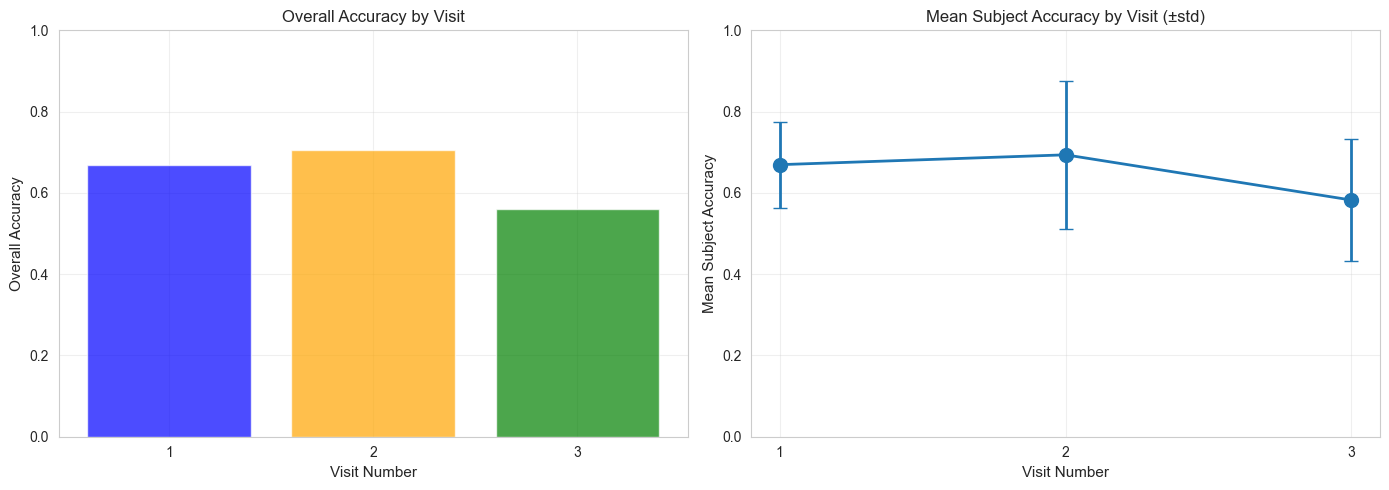

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall accuracy by visit
axes[0].bar([1, 2, 3], comparison_df['Accuracy'], 
           color=['blue', 'orange', 'green'], alpha=0.7)
axes[0].set_xlabel('Visit Number')
axes[0].set_ylabel('Overall Accuracy')
axes[0].set_title('Overall Accuracy by Visit')
axes[0].set_ylim(0, 1)
axes[0].set_xticks([1, 2, 3])
axes[0].grid(True, alpha=0.3)

# Mean subject accuracy with error bars
axes[1].errorbar([1, 2, 3], comparison_df['Mean_Subject_Acc'], 
                yerr=comparison_df['Std_Subject_Acc'],
                marker='o', capsize=5, linewidth=2, markersize=10)
axes[1].set_xlabel('Visit Number')
axes[1].set_ylabel('Mean Subject Accuracy')
axes[1].set_title('Mean Subject Accuracy by Visit (±std)')
axes[1].set_ylim(0, 1)
axes[1].set_xticks([1, 2, 3])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Distribution of Subject Accuracies


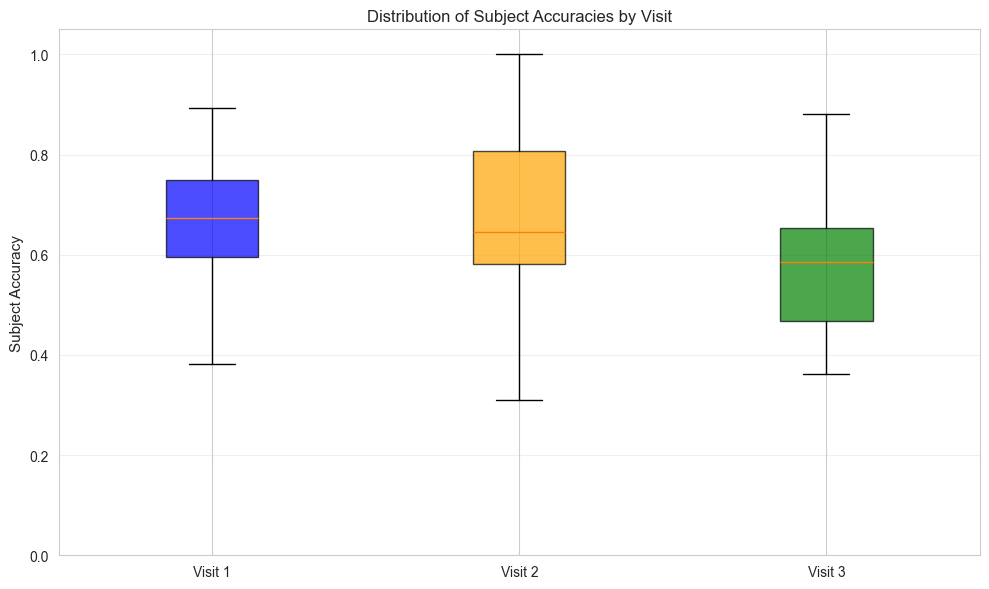

In [13]:
# Box plot of subject accuracies
plt.figure(figsize=(10, 6))

data_for_box = [
    results_v1['subject_accuracies'],
    results_v2['subject_accuracies'],
    results_v3['subject_accuracies']
]

bp = plt.boxplot(data_for_box, labels=['Visit 1', 'Visit 2', 'Visit 3'],
                patch_artist=True)

# Color the boxes
colors = ['blue', 'orange', 'green']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel('Subject Accuracy')
plt.title('Distribution of Subject Accuracies by Visit')
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


## Save Results


In [14]:
import os
os.makedirs(f'../../data/results/fusion_model_results_{TIMEFRAME}', exist_ok=True)

# Save comparison results
output_file = f'../../data/results/fusion_model_results_{TIMEFRAME}/late_fusion_by_visit_{TIMEFRAME}_comparison.csv'
comparison_df.to_csv(output_file, index=False)
print(f"✓ Saved comparison to: {output_file}")

# Save detailed results
results_dict = {
    'visit_1': results_v1,
    'visit_2': results_v2,
    'visit_3': results_v3
}

output_file = f'../../data/results/fusion_model_results_{TIMEFRAME}/late_fusion_by_visit_{TIMEFRAME}_detailed_results.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(results_dict, f)
print(f"✓ Saved detailed results to: {output_file}")

print(f"\n✓ All results saved to: ../../data/results/fusion_model_results_{TIMEFRAME}/")

✓ Saved comparison to: ../../data/results/fusion_model_results_PRE/late_fusion_by_visit_PRE_comparison.csv
✓ Saved detailed results to: ../../data/results/fusion_model_results_PRE/late_fusion_by_visit_PRE_detailed_results.pkl

✓ All results saved to: ../../data/results/fusion_model_results_PRE/
